<a href="https://colab.research.google.com/github/Ssurf777/VAE_sample/blob/main/ModelNet10_VAE_Heat_Eq/VAE_Chair_Heat_Eq_20240916_faiss_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE

In [3]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.0 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import transforms, utils
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import random
from sklearn.cluster import MiniBatchKMeans
import torch.nn.functional as F
import torch
import faiss
from sklearn.cluster import DBSCAN



In [5]:
# ランダムシードの設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [6]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points

# クラスタリング
def create_clusters(points, k=4):
    distances = torch.cdist(points, points)
    clusters = []
    for i in range(len(points)):
        closest_neighbors_idx = torch.topk(distances[i], k + 1, largest=False)[1][1:]
        clusters.append(points[closest_neighbors_idx])
    return clusters

def create_clusters_with_kmeans(points, k=4, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(points.detach().cpu().numpy())  # detach() を追加
    labels = kmeans.labels_
    clusters = []

    for label in range(n_clusters):
        cluster_points = points[torch.tensor(labels) == label]
        if len(cluster_points) > k:
            clusters.extend(create_clusters(cluster_points, k=k))
        else:
            clusters.append(cluster_points)

    return clusters


def create_clusters_with_faiss_dbscan(points, k=4, eps=0.5, min_samples=5):
    # Convert points to numpy array for faiss processing
    points_np = points.detach().cpu().numpy()

    # Use faiss to build an index for efficient similarity search
    d = points_np.shape[1]  # Dimensionality of the points
    index = faiss.IndexFlatL2(d)
    index.add(points_np)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(points_np)

    clusters = []

    # Find unique labels (-1 indicates noise in DBSCAN, so we skip it)
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    for label in unique_labels:
        cluster_points = points[torch.tensor(labels) == label]
        if len(cluster_points) > k:
            clusters.extend(create_clusters(cluster_points, k=k))
        else:
            clusters.append(cluster_points)

    return clusters

# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i]
            laplacian += grad2_T

        laplacians.append(laplacian.mean())
    return torch.stack(laplacians)

# PINNの学習
def train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #clusters = create_clusters_with_kmeans(points, k=k)
    clusters = create_clusters_with_faiss_dbscan(points, k=k)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i, point in enumerate(points):
            distance_to_source = torch.norm(point - heat_source)
            expected_temperature = 1 / (distance_to_source + 1e-8)

            laplacian = compute_laplacian_with_clusters(model, [clusters[i]])
            #laplacian = compute_laplacian_with_clusters_batch(model, [clusters[i]], batch_size=32)
            loss_laplacian = torch.mean(laplacian[0] ** 2)
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)

            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss / len(points)}')


# DBSCAN参考
https://data-analysis-stats.jp/python/dbscan%e3%82%af%e3%83%a9%e3%82%b9%e3%82%bf%e3%83%bc%e3%81%ae%e8%a7%a3%e8%aa%ac%e3%81%a8%e5%ae%9f%e9%a8%93/

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,5)]

input_data_list = []
input_data_list2 = []

for file_name in file_names:
  with open(file_name, 'r') as f:
    verts, faces = read_off(f)

    i,j,k = np.array(faces).T
    x,y,z = np.array(verts).T

    pointcloud = PointSampler(100)((verts,faces))

    # traindata
    train_x = pointcloud[:,0]
    train_y = pointcloud[:,1]
    train_z = pointcloud[:,2]

    train_xn = (train_x - train_x.min())/(train_x.max() - train_x.min())
    train_yn = (train_y - train_y.min())/(train_y.max() - train_y.min())
    train_zn = (train_z - train_z.min())/(train_z.max() - train_z.min())

    # data combine
    combined_data = np.concatenate((train_xn,train_yn,train_zn))

    # input data
    input_data_list.append(combined_data)
    combined_data2 = np.vstack((train_xn, train_yn, train_zn)).T
    input_data_list2.append(combined_data2)

  input_data = np.stack(input_data_list)
  #input_tensor = torch.tensor(input_data, dtype=torch.float32).cuda()
  input_tensor = torch.tensor(input_data, dtype=torch.float32)
  batch_size = 1
  dataset = TensorDataset(input_tensor)
  data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)

In [9]:
# training setting
eta = 0.001
epochs = 500
batch_size = 1
interval = 10

In [12]:

num_points = 100
n_in_out = 3 * num_points
n_make_out = 4 * num_points
n_mid1 = 512
n_mid2 = 256
n_mid3 = 128
n_mid4 = 64
n_mid5 = 32
n_z = 3 # 潜在変数の数

class PointnetVAE(nn.Module):
    def __init__(self):
        super(PointnetVAE, self).__init__()

        # PointNet Encoder
        self.conv1 = nn.Conv1d(n_in_out, 64, kernel_size=1)  # 通常は1D-CNNの後にbatchnormを入れるがbatchsize=1なので無
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)  # 通常は1D-CNNの後にbatchnormを入れるがbatchsize=1なので無
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1) # 通常は1D-CNNの後にbatchnormを入れるがbatchsize=1なので無
        # self.maxpool = nn.MaxPool1d(kernel_size=num_points)
        self.maxpool = nn.AdaptiveMaxPool1d(1)  # 出力サイズを常に1に設定
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 9)
        self.enc_mu = nn.Linear(9, n_z)
        self.enc_logvar = nn.Linear(9, n_z)

        # Decoder
        self.dec1 = nn.Linear(n_z, n_mid5)
        self.dec2 = nn.Linear(n_mid5, n_mid4)
        self.dec3 = nn.Linear(n_mid4, n_mid3)
        self.dec4 = nn.Linear(n_mid3, n_mid2)
        self.dec5 = nn.Linear(n_mid2, n_mid1)
        self.dec_out = nn.Linear(n_mid1, n_make_out) #decoderからはx,y,z,Tが出力される

        # weight initial
        self._init_weights()

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        y = self.decode(z)
        return y, z, mu, logvar  # 4つの値を返す

    def encode(self, x):
        x = x.reshape(1, n_in_out, 1)
        x = F.leaky_relu(self.conv1(x), negative_slope=0.001)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.001)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.001)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # フラット化してlinear層に接続
        x = F.leaky_relu(self.linear1(x), negative_slope=0.001)
        x = F.leaky_relu(self.linear2(x), negative_slope=0.001)
        x = self.linear3(x)
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)
        std = torch.exp(0.5 * logvar)  # sigma
        eps = torch.randn_like(std)  # 正規分布に従う乱数
        z = mu + std * eps  # 潜在変数
        self.mu = mu
        self.logvar = logvar
        return z, mu, logvar

    def decode(self, z):
        x = F.leaky_relu(self.dec1(z), negative_slope=0.001)
        x = F.leaky_relu(self.dec2(x), negative_slope=0.001)
        x = F.leaky_relu(self.dec3(x), negative_slope=0.001)
        x = F.leaky_relu(self.dec4(x), negative_slope=0.001)
        x = F.leaky_relu(self.dec5(x), negative_slope=0.001)
        x = torch.sigmoid(self.dec_out(x))
        return x

    def loss(self, recon_x, x, mu, logvar):
        # デコーダからの出力を3次元の位置情報と温度に分ける
        reconst_x = recon_x[:, :100]
        reconst_y = recon_x[:, 100:200]
        reconst_z = recon_x[:, 200:300]
        reconst_t = recon_x[:, 300:400]
        recon_points = torch.stack((reconst_x, reconst_y, reconst_z), dim=1)

        # オリジナルの入力も3次元の位置情報に整形
        x = x.view(-1, n_in_out)
        x_x = x[:, :100]
        x_y = x[:, 100:200]
        x_z = x[:, 200:300]

        # 再構成誤差 (MSE) の計算
        mse_x = F.mse_loss(reconst_x, x_x, reduction="sum")
        mse_y = F.mse_loss(reconst_y, x_y, reduction="sum")
        mse_z = F.mse_loss(reconst_z, x_z, reduction="sum")
        rec_loss = mse_x + mse_y + mse_z

        # KLダイバージェンスによる正則化項の計算
        reg_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # クラスタの作成
        #clusters = create_clusters_with_kmeans(recon_points.view(-1, 3), k=4, n_clusters=5)
        clusters = create_clusters_with_faiss_dbscan(recon_points.view(-1, 3), k=4)
        # ラプラシアンの計算
        laplacian = compute_laplacian_with_clusters(self.decode, clusters)
        loss_laplacian = torch.mean(laplacian ** 2)

        # 温度損失の計算
        heat_source = torch.tensor([0.0, 0.0, 0.0]).to(recon_points.device)  # 熱源の位置を定義
        loss_temperature = 0
        for i in range(recon_points.shape[2]):  # 修正
            point = recon_points[:, :, i]  # 3次元座標の各ポイントを取得
            distance_to_source = torch.norm(point - heat_source, dim=0)
            expected_temperature = 1 / (distance_to_source + 1e-8)
            loss_temperature += torch.mean((reconst_t[:, i] - expected_temperature) ** 2)

        loss_temperature /= recon_points.shape[2]
        return rec_loss, reg_loss, loss_laplacian, loss_temperature

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

vae = PointnetVAE()
print(vae)
#vae.cuda()

PointnetVAE(
  (conv1): Conv1d(300, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (maxpool): AdaptiveMaxPool1d(output_size=1)
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=9, bias=True)
  (enc_mu): Linear(in_features=9, out_features=3, bias=True)
  (enc_logvar): Linear(in_features=9, out_features=3, bias=True)
  (dec1): Linear(in_features=3, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=400, bias=True)
)


In [13]:
import warnings
import time

warnings.filterwarnings("ignore", category=FutureWarning) # warningの非表示化

optimizer = optim.Adam(vae.parameters(), lr=eta)

rec_error_record = []
reg_error_record = []
laplacian_error_record = []
temperature_error_record = []
total_error_record = []
z_list = []

start_time = time.time()

for i in range(epochs):
    epoch_start_time = time.time()
    vae.train()
    loss_rec = 0
    loss_reg = 0
    loss_laplacian = 0
    loss_temperature = 0
    loss_total = 0

    for j, (x,) in enumerate(data_loader):
        #x = x.cuda()
        y, z, mu, logvar = vae(x)  # muとlogvarを返すようにforward関数を修正する
        #total_loss = vae.loss(y, x, mu, logvar)  # 修正後のloss関数を使用
        lrec, lreg, llaplacian, ltemperature = vae.loss(y, x, mu, logvar)
        # それぞれの損失項を合計して total_loss を計算する
        total_loss = lrec + lreg + llaplacian + ltemperature
        loss_rec += lrec.item()
        loss_reg += lreg.item()
        loss_laplacian += llaplacian.item()
        loss_temperature += ltemperature.item()
        loss_total += total_loss.item()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if i == epochs - 1:
            z_list.append(z.cpu().detach().numpy())

    loss_rec /= j + 1
    loss_reg /= j + 1
    loss_laplacian /= j + 1
    loss_temperature /= j + 1
    loss_total /= j + 1

    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    laplacian_error_record.append(loss_laplacian)
    temperature_error_record.append(loss_temperature)
    total_error_record.append(loss_total)

    epoch_time = time.time() - epoch_start_time
    elapsed_time = time.time() - start_time
    remaining_epochs = epochs - ( i + 1)
    estimated_remaining_time = (elapsed_time / (i + 1)) * remaining_epochs
    if i % interval == 0:
        print(f"Epoch:{i + 1}/{epochs}| Elapsed Time: {elapsed_time:.2f}s | Elapsed Time Remaining: {estimated_remaining_time:.2f}s")
        print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Laplacian:{loss_laplacian} Loss_Temperature:{loss_temperature} Loss_Total:{loss_total}")

z_list = np.concatenate(z_list, axis=0)


Epoch:1/500| Elapsed Time: 4.72s | Elapsed Time Remaining: 2355.10s
Epoch:0 Loss_Rec:27.76060962677002 Loss_Reg:0.03195871412754059 Loss_Laplacian:1.5216098745440831e-06 Loss_Temperature:2.225066363811493 Loss_Total:30.0176362991333
Epoch:11/500| Elapsed Time: 51.65s | Elapsed Time Remaining: 2296.00s
Epoch:10 Loss_Rec:21.687567234039307 Loss_Reg:0.006342053413391113 Loss_Laplacian:0.2013362217694521 Loss_Temperature:1.5702913701534271 Loss_Total:23.465537071228027
Epoch:21/500| Elapsed Time: 99.72s | Elapsed Time Remaining: 2274.50s
Epoch:20 Loss_Rec:20.88588809967041 Loss_Reg:0.0019182711839675903 Loss_Laplacian:0.27888964489102364 Loss_Temperature:1.457062542438507 Loss_Total:22.623759746551514
Epoch:31/500| Elapsed Time: 154.95s | Elapsed Time Remaining: 2344.23s
Epoch:30 Loss_Rec:20.930749893188477 Loss_Reg:0.012093953788280487 Loss_Laplacian:0.11815592274069786 Loss_Temperature:1.3506078124046326 Loss_Total:22.411608695983887
Epoch:41/500| Elapsed Time: 204.71s | Elapsed Time Rem

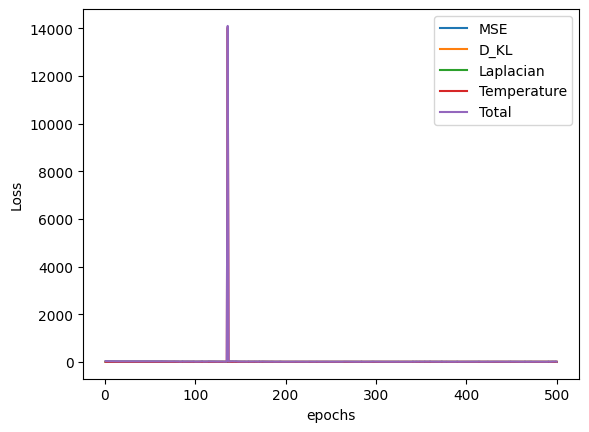

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(rec_error_record)+1),rec_error_record,label="MSE")
plt.plot(range(1, len(reg_error_record)+1),reg_error_record,label="D_KL")
plt.plot(range(1, len(laplacian_error_record)+1),laplacian_error_record,label="Laplacian")
plt.plot(range(1, len(temperature_error_record)+1),temperature_error_record,label="Temperature")

plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()


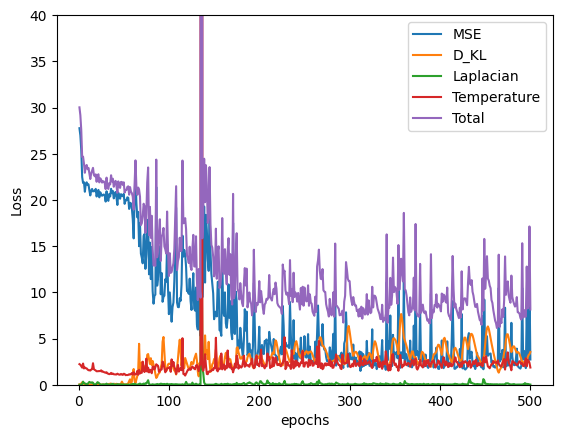

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(rec_error_record) + 1), rec_error_record, label="MSE")
plt.plot(range(1, len(reg_error_record) + 1), reg_error_record, label="D_KL")
plt.plot(range(1, len(laplacian_error_record) + 1), laplacian_error_record, label="Laplacian")
plt.plot(range(1, len(temperature_error_record) + 1), temperature_error_record, label="Temperature")
plt.plot(range(1, len(total_error_record) + 1), total_error_record, label="Total")

plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")

# 縦軸の範囲を0~10に設定
plt.ylim(0, 40)

plt.show()


In [16]:

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_point_cloud(xs, ys, zs, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        show_plot = True
    else:
        show_plot = False

    ax.scatter(xs, ys, zs, s=1)
    ax.set_title(title)
    if show_plot:
        plt.show()

def plot_point_cloud_with_temperature(xs, ys, zs, temperatures, title="Point Cloud with Temperature", ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        show_plot = True
    else:
        show_plot = False
        # Get the figure from the axes object
        fig = ax.get_figure()

    # 温度に基づいてポイントクラウドの色を設定
    scatter = ax.scatter(xs, ys, zs, c=temperatures, cmap='jet', s=20)
    ax.set_title(title)

    # カラーバーを追加して温度のスケールを表示
    fig.colorbar(scatter, ax=ax, label='Temperature')

    if show_plot:
        plt.show()


# 潜在変数z_listを2次元に縮退
perplexity = 3  # perplexityを5に設定
tsne = TSNE(n_components=2, perplexity=perplexity)
z_list_2d = tsne.fit_transform(z_list)

# z_list_2dの範囲を取得
z1_min, z1_max = z_list_2d[:, 0].min(), z_list_2d[:, 0].max()
z2_min, z2_max = z_list_2d[:, 1].min(), z_list_2d[:, 1].max()

print(f"z1 range: {z1_min} to {z1_max}")
print(f"z2 range: {z2_min} to {z2_max}")


z1 range: -82.47142028808594 to -20.717329025268555
z2 range: -33.44001770019531 to 28.233652114868164


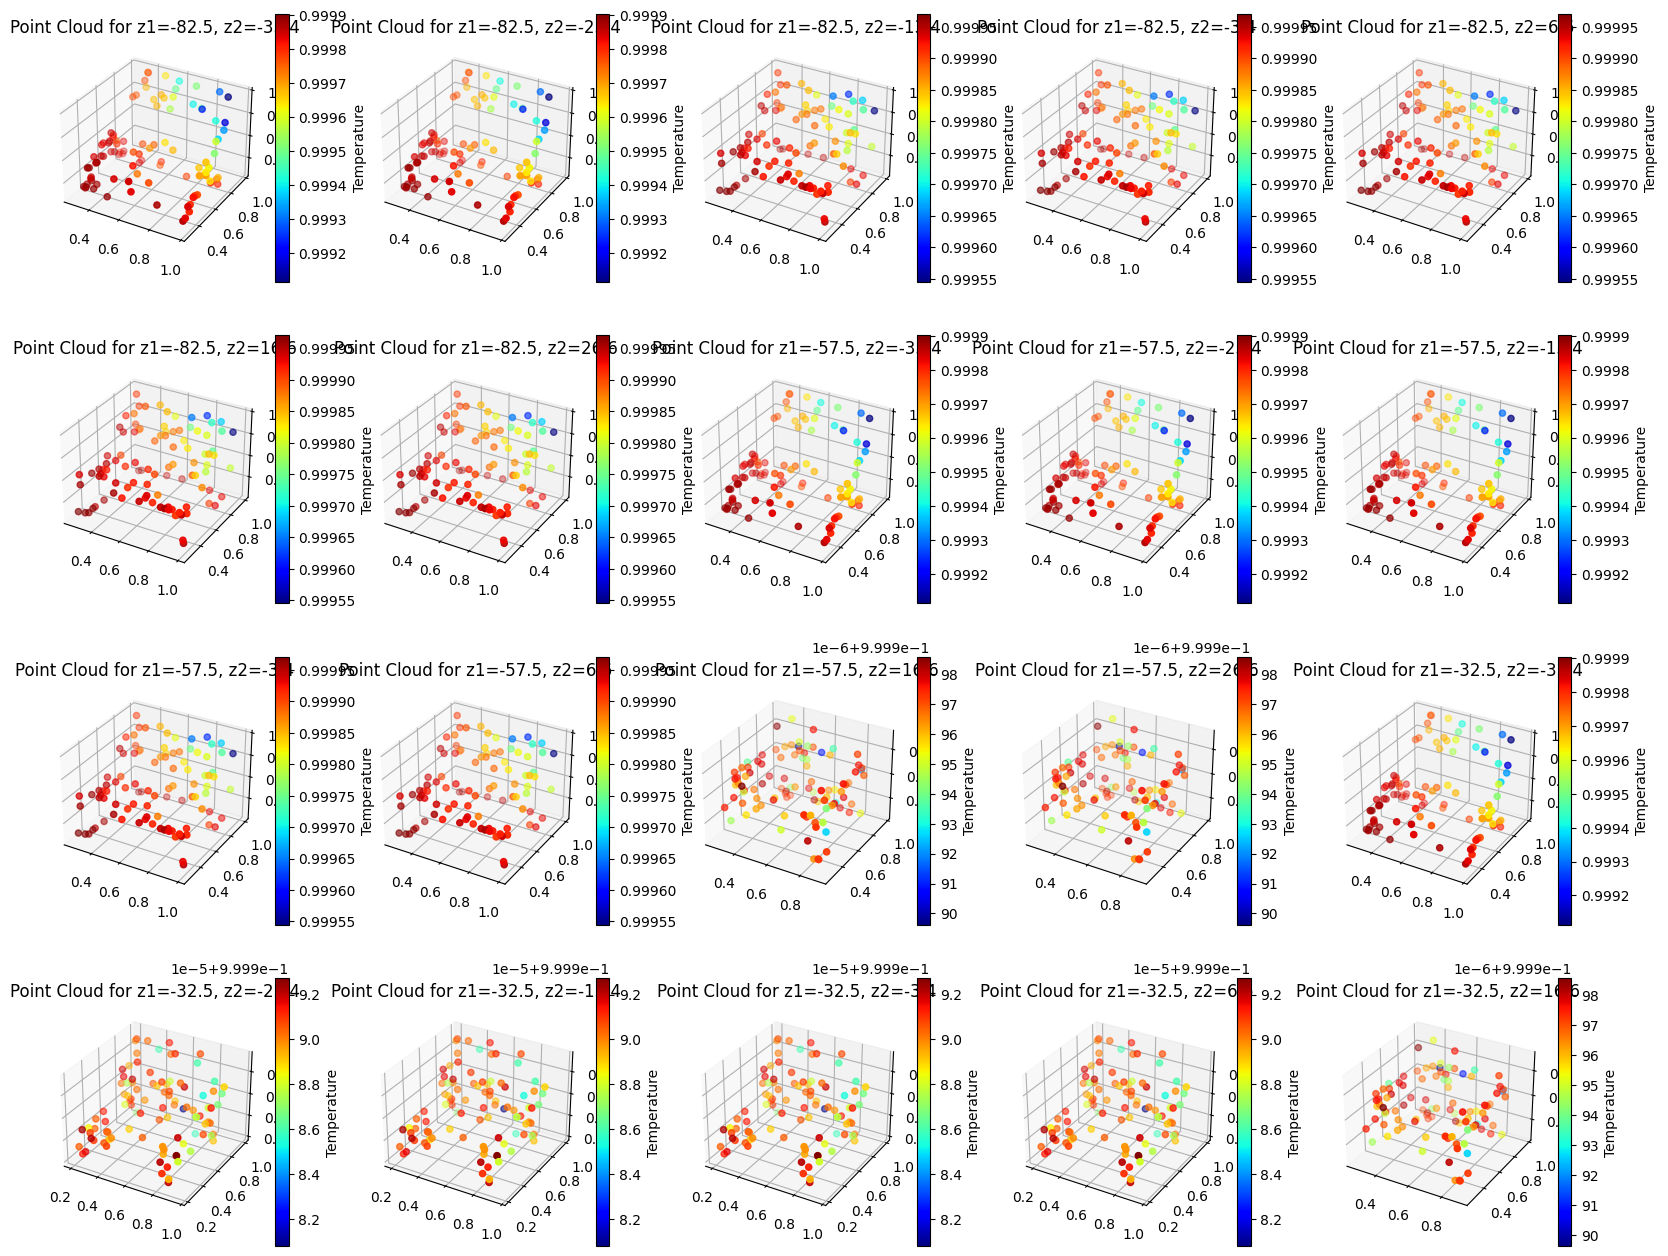

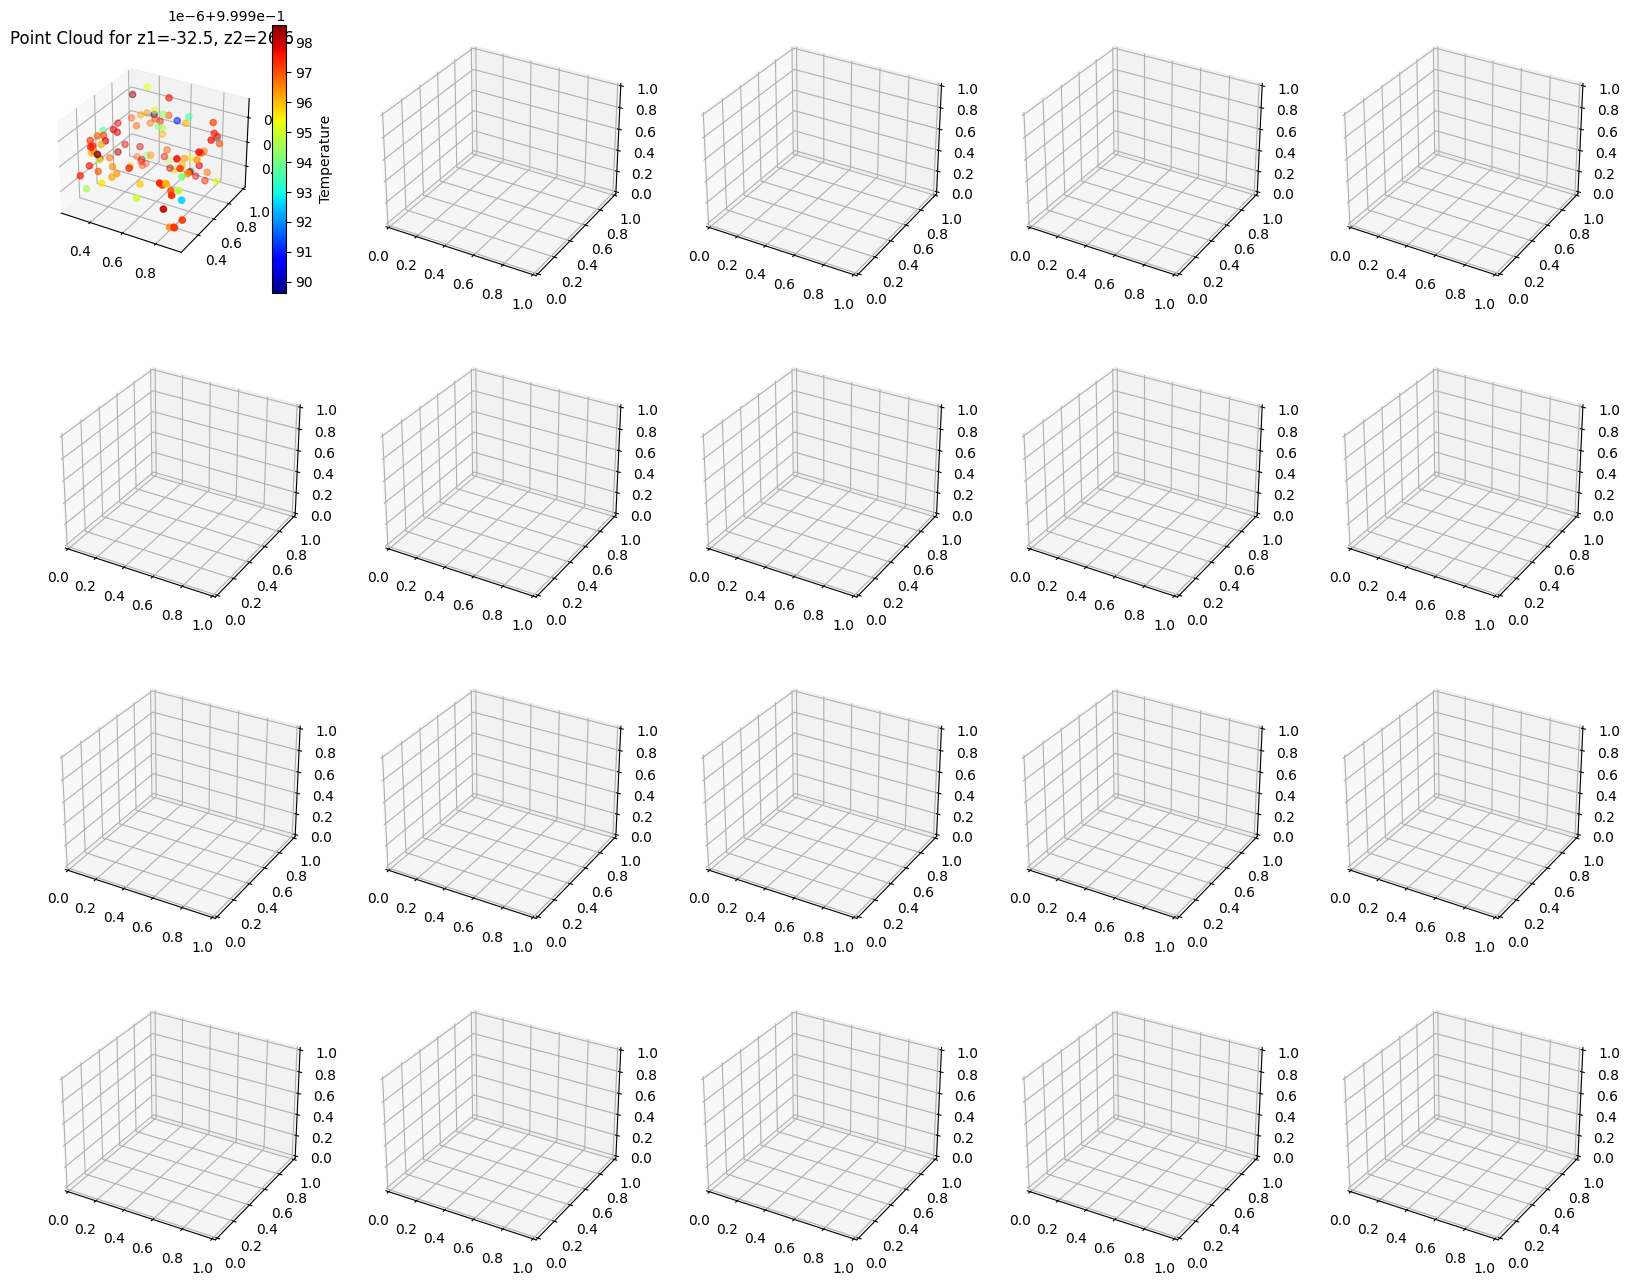

In [19]:
# ループして潜在変数を変化させ、再構築と可視化を行う
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16), subplot_kw={'projection': '3d'})
axes = axes.flatten()

index = 0
for z1 in np.arange(z1_min, z1_max + 0.2, 25):
    for z2 in np.arange(z2_min, z2_max + 0.2, 10):
        if index >= len(axes):
            plt.show()
            fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16), subplot_kw={'projection': '3d'})
            axes = axes.flatten()
            index = 0

        # t-SNEの逆変換を行うために最近傍の16次元の潜在変数を取得
        dist = np.linalg.norm(z_list_2d - np.array([z1, z2]), axis=1)
        nearest_index = np.argmin(dist)
        z_mod = torch.tensor(z_list[nearest_index], dtype=torch.float32).unsqueeze(0)

        # 再構築
        recon_batch2 = vae.decode(z_mod)
        reconst2 = recon_batch2.detach().numpy().reshape(-1)
        reconst2_x = reconst2[:100]
        reconst2_y = reconst2[100:200]
        reconst2_z = reconst2[200:300]
        reconst2_t = reconst2[300:400]

        title = f"Point Cloud for z1={z1:.1f}, z2={z2:.1f}"
        plot_point_cloud_with_temperature(reconst2_x, reconst2_y, reconst2_z, reconst2_t, title, axes[index])
        index += 1

# 最後に残ったプロットを表示
if index > 0:
    plt.show()